The purpose of this notebook is to build a CNN using feature extraction and fine-tuning on the EfficientNetV2B0 model. The dataset used can be found here:
https://www.kaggle.com/datasets/gpiosenka/sports-classification.

The test, train, and validation set sizes have been modified to give the test and validation a larger portion of the overall dataset size. Orginally they were around 3% each of the total, I increased their size to about 10% each of the total by removing some images from the training set. The same amount of images was added for each class.

In [1]:
# Making a new local folder and moving the data from my drive to the folder so it loads into the model training faster

!mkdir data
!cp -r /content/drive/MyDrive/sports_images.zip /content/data

In [2]:
# Unzipping the file and extracting the datasets

import zipfile
zip_ref = zipfile.ZipFile("/content/data/sports_images.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
# Getting class names for the next function

import os
import shutil
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Create list of class names from subdirectories
print(class_names)

['air hockey' 'ampute football' 'archery' 'arm wrestling' 'axe throwing'
 'balance beam' 'barell racing' 'baseball' 'basketball' 'baton twirling'
 'bike polo' 'billiards' 'bmx' 'bobsled' 'bowling' 'boxing' 'bull riding'
 'bungee jumping' 'canoe slamon' 'cheerleading' 'chuckwagon racing'
 'cricket' 'croquet' 'curling' 'disc golf' 'fencing' 'field hockey'
 'figure skating men' 'figure skating pairs' 'figure skating women'
 'fly fishing' 'football' 'formula 1 racing' 'frisbee' 'gaga'
 'giant slalom' 'golf' 'hammer throw' 'hang gliding' 'harness racing'
 'high jump' 'hockey' 'horse jumping' 'horse racing' 'horseshoe pitching'
 'hurdles' 'hydroplane racing' 'ice climbing' 'ice yachting' 'jai alai'
 'javelin' 'jousting' 'judo' 'lacrosse' 'log rolling' 'luge'
 'motorcycle racing' 'mushing' 'nascar racing' 'olympic wrestling'
 'parallel bar' 'pole climbing' 'pole dancing' 'pole vault' 'polo'
 'pommel horse' 'rings' 'rock climbing' 'roller derby'
 'rollerblade racing' 'rowing' 'rugby' 'sailboat

In [4]:
# Moving images from the train set to the test and validation sets to give them a greater sample size (about 10%)

import random
def move_images(src_path, dst_path, num_images=9, classes = class_names):
  """
  Moves image files designed to be used in classification tasks from the current folder to the target folder
  """
  for class_name in classes:
    src_folder = src_path + "/" + class_name
    dst_folder = dst_path + "/" + class_name
    random_images = random.sample(os.listdir(src_folder), num_images)
    for i in range(len(random_images)):
      shutil.move(src_folder + "/" + random_images[i], dst_folder + "/" + random_images[i])

In [5]:
for directory in ["/content/test", "/content/valid"]:
  move_images("/content/train", directory)

In [6]:
import tensorflow as tf

# Defining data directory paths
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/valid"

# Defining image and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Getting data into image, label tuples
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 11692 files belonging to 100 classes.
Found 1400 files belonging to 100 classes.
Found 1400 files belonging to 100 classes.


In [7]:
# Plotting random images to get an idea of what the data looks like

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
def view_random_image(data, directory):
  target_class = random.choice(data.class_names)
  target_dir = directory + "/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + "/" + random_image

  # Read in and plot random image
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  plt.title(f"{target_class}")
  plt.axis(False);

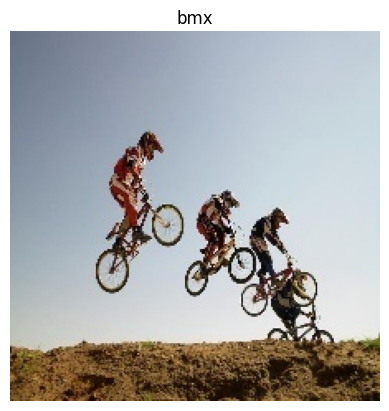

In [8]:
view_random_image(val_data, val_dir)

In [9]:
def view_multiple_images(data, directory, rows=2, columns=2):
  plt.figure(figsize=(10, 10))
  for row in range(rows):
    for col in range(columns):
      plt.subplot(rows, columns, columns * row + col + 1)
      view_random_image(data, directory)

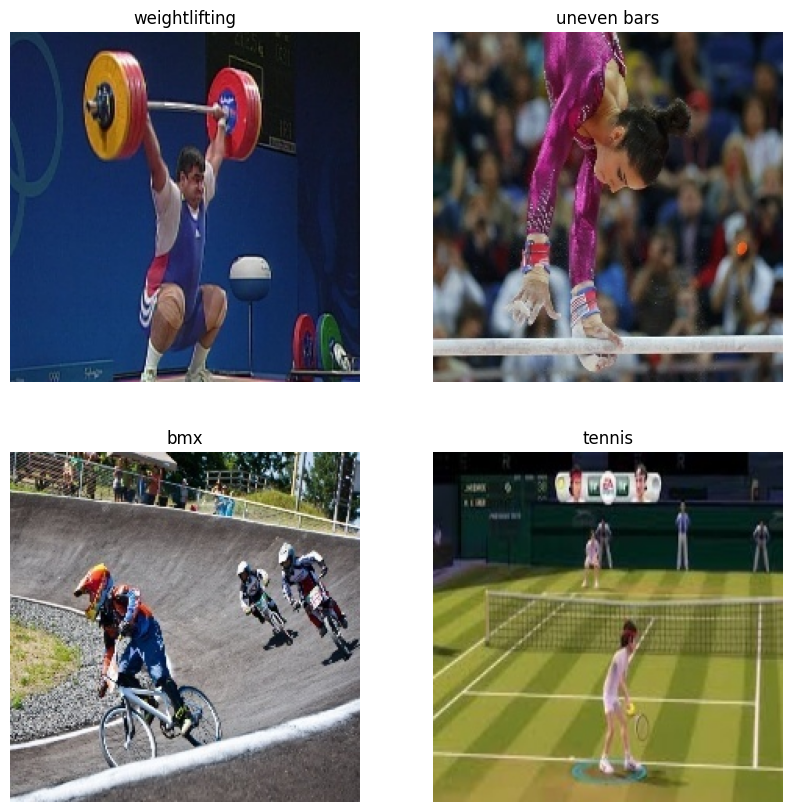

In [10]:
view_multiple_images(train_data, train_dir, 2, 2)

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Creating data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

# Import base model and freeze layers
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)

# Define layers and create the model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_1 = model.fit(train_data,
                      epochs = 5,
                      validation_data = val_data)

Epoch 1/5
366/366 [==============================] - 265s 695ms/step - loss: 2.1833 - accuracy: 0.5416 - val_loss: 0.8151 - val_accuracy: 0.8321
Epoch 2/5
366/366 [==============================] - 161s 440ms/step - loss: 1.0081 - accuracy: 0.7626 - val_loss: 0.5181 - val_accuracy: 0.8850
Epoch 3/5
366/366 [==============================] - 125s 340ms/step - loss: 0.7757 - accuracy: 0.8103 - val_loss: 0.4294 - val_accuracy: 0.8929
Epoch 4/5
366/366 [==============================] - 106s 286ms/step - loss: 0.6521 - accuracy: 0.8344 - val_loss: 0.3815 - val_accuracy: 0.9014
Epoch 5/5
366/366 [==============================] - 83s 226ms/step - loss: 0.5652 - accuracy: 0.8552 - val_loss: 0.3467 - val_accuracy: 0.9057


In [13]:
# Looking at the loss and accuracy metrics in relation to the number of epochs that have passed. Taken from: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [14]:
test_acc_1 = model.evaluate(test_data)
test_acc_1

44/44 [==============================] - 2s 50ms/step - loss: 0.3402 - accuracy: 0.9093


[0.3401578664779663, 0.9092857241630554]

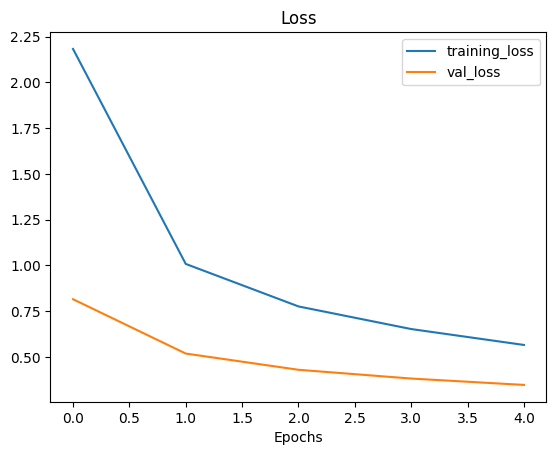

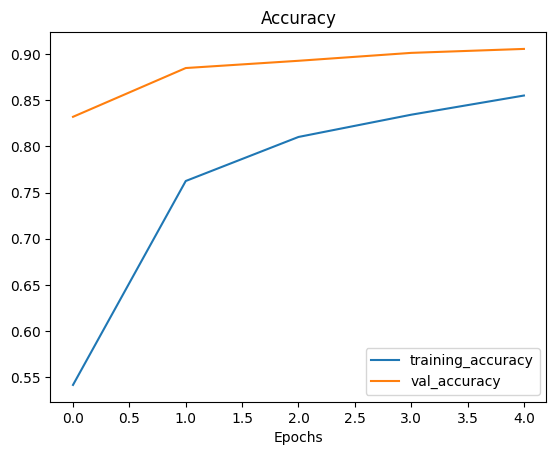

In [15]:
plot_loss_curves(history_1)

In [16]:
# Unfreezing the top 10 layers in the base model to begin fine-tuning

base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompiling the model with a lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

history_2 = model.fit(train_data,
                      epochs=10,
                      validation_data=val_data,
                      initial_epoch=history_1.epoch[-1])

Epoch 5/10
366/366 [==============================] - 95s 233ms/step - loss: 0.4630 - accuracy: 0.8679 - val_loss: 0.3000 - val_accuracy: 0.9086
Epoch 6/10
366/366 [==============================] - 75s 202ms/step - loss: 0.3996 - accuracy: 0.8846 - val_loss: 0.3135 - val_accuracy: 0.9021
Epoch 7/10
366/366 [==============================] - 69s 188ms/step - loss: 0.3689 - accuracy: 0.8944 - val_loss: 0.2878 - val_accuracy: 0.9100
Epoch 8/10
366/366 [==============================] - 65s 177ms/step - loss: 0.3403 - accuracy: 0.8990 - val_loss: 0.2831 - val_accuracy: 0.9071
Epoch 9/10
366/366 [==============================] - 55s 149ms/step - loss: 0.3140 - accuracy: 0.9106 - val_loss: 0.2999 - val_accuracy: 0.9064
Epoch 10/10
366/366 [==============================] - 60s 162ms/step - loss: 0.3118 - accuracy: 0.9111 - val_loss: 0.3054 - val_accuracy: 0.8993


In [17]:
test_acc_2 = model.evaluate(test_data)
test_acc_2

44/44 [==============================] - 2s 52ms/step - loss: 0.2648 - accuracy: 0.9193


[0.26481306552886963, 0.9192857146263123]

In [19]:
# Comparing loss and accuracy before and after fine-tuning. Taken from: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

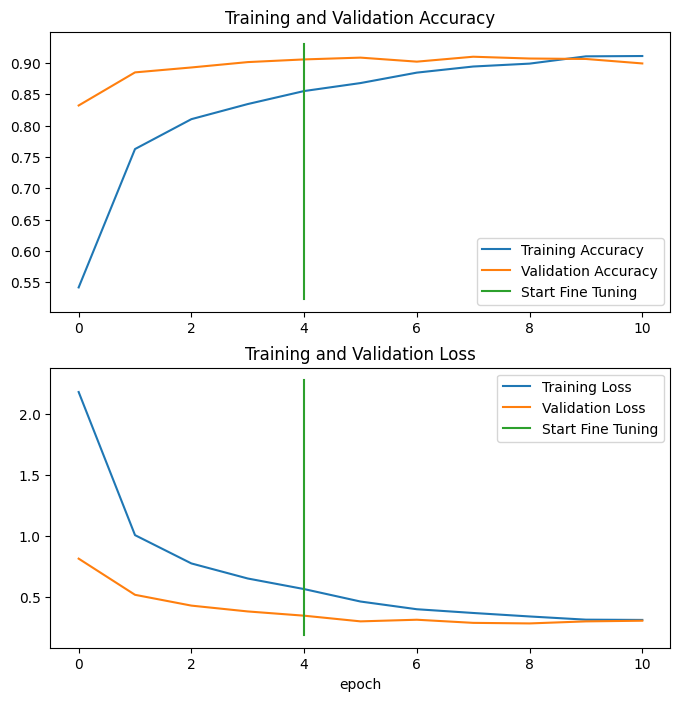

In [20]:
compare_histories(history_1, history_2, 5)

In [26]:
def visualize_image_and_predict(model, target_dir, classes=class_names):
  """
  Plots a random image and displays the actual and predicted class and the probability.

  Takes in a model, a directory, and a list of class names.
  """

  target_class = random.choice(classes)
  target_path = target_dir +  "/" + target_class
  image = random.choice(os.listdir(target_path))
  image_path = target_path + "/" + image
  img = mpimg.imread(image_path)

  pred_prob = model.predict(tf.image.resize(tf.expand_dims(img, axis=0), [224, 224]))
  pred_class = classes[np.argmax(pred_prob)]

  plt.figure()
  if pred_class == target_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.imshow(img)
  plt.title(f"Actual: {target_class}. Predicted: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

1/1 [==============================] - 0s 26ms/step


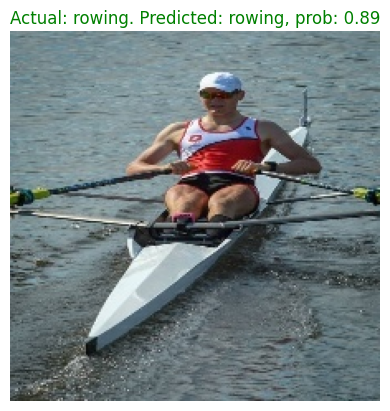

In [29]:
visualize_image_and_predict(model, "/content/test")